In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
#np.seterr(divide='print', invalid='print')
from scipy.sparse import hstack, csr_matrix
from xgboost import XGBClassifier
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import IPython
from plotly.offline import init_notebook_mode
%matplotlib inline
import plotly.offline as offline
from sklearn.calibration import CalibratedClassifierCV
import plotly.graph_objs as go
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import log_loss
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from prettytable import PrettyTable
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
import pickle

from common_functions import *

## Dataset - Loading

In [2]:
train_dataset = pd.read_csv("data/UNSW_NB15_training-set.csv", encoding = "ISO-8859-1")
train_dataset.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,...,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,...,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,...,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,...,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,...,1,40,0,0,0,2,39,0,Normal,0


In [3]:
test_dataset = pd.read_csv("data/UNSW_NB15_testing-set.csv", encoding = "ISO-8859-1")
test_dataset.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.0902,...,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.0003,...,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.0051,...,1,3,0,0,0,1,3,0,Normal,0
3,4,0.000006,udp,-,INT,2,0,900,0,166666.6608,...,1,3,0,0,0,2,3,0,Normal,0
4,5,0.000010,udp,-,INT,2,0,2126,0,100000.0025,...,1,3,0,0,0,2,3,0,Normal,0


In [4]:
#taking balanced samples of dataset for training
#reference - https://stackoverflow.com/questions/41035187/stratified-samples-from-pandas

#dataset for training attack classification
# train_dataset = train_dataset.groupby('attack_cat').apply(lambda x: x.sample(3000, replace=True))

In [5]:
X_train, X_cv, y_train, y_cv = train_test_split(train_dataset.drop(['attack_cat', 'label'], axis=1), train_dataset.attack_cat, test_size=0.20)
X_test, y_test = test_dataset.drop(['attack_cat', 'label'], axis=1), test_dataset.attack_cat

In [6]:
with open("binary_features", "rb") as fp:   # Unpickling binary features
    binary_features = pickle.load(fp)

with open("categorical_features", "rb") as fp:   # Unpickling categorical features
    categorical_features = pickle.load(fp)

with open("numerical_features", "rb") as fp:   # Unpickling numerical features
    numerical_features = pickle.load(fp)


In [7]:
one_hot_encoders, one_hot_encoders_features = fit_one_hot_encoders(X_train, categorical_features)
feature_standardizers = fit_standard_scalars(X_train, numerical_features)
minmax_scalers = fit_minmax_scalars(X_train, numerical_features)

X_train_encoded, X_train_encoded_features = merge_all(X_train, 
                                                      one_hot_encoders_features, 
                                                      get_one_hot_encoded_features(X_train, categorical_features, one_hot_encoders), 
                                                      get_standardized_features(X_train, numerical_features, feature_standardizers), 
                                                      binary_features)

X_cv_encoded, _ = merge_all(X_cv, one_hot_encoders_features, 
                                                      get_one_hot_encoded_features(X_cv, categorical_features, one_hot_encoders), 
                                                      get_standardized_features(X_cv, numerical_features, feature_standardizers), 
                                                      binary_features)

X_test_encoded, _ = merge_all(X_test, one_hot_encoders_features, 
                                                      get_one_hot_encoded_features(X_test, categorical_features, one_hot_encoders), 
                                                      get_standardized_features(X_test, numerical_features, feature_standardizers), 
                                                      binary_features)

#label encode attack category
y_encoder = LabelEncoder().fit(y_train)
y_train = np.array(y_encoder.transform(y_train))
y_cv = np.array(y_encoder.transform(y_cv))
y_test = np.array(y_encoder.transform(y_test))

#attack categories
print('\n y classes :' + str(y_encoder.classes_))


One Hot Encoding for proto
Feature Names are :
['25', '3pc', 'aes', 'any', 'argus', 'aris', 'arp', 'ax', 'bbn', 'bna', 'br', 'cbt', 'cftp', 'chaos', 'cmtp', 'compaq', 'cphb', 'cpnx', 'crtp', 'crudp', 'dcn', 'ddp', 'ddx', 'dgp', 'egp', 'eigrp', 'emcon', 'enc', 'encap', 'etherip', 'expak', 'fc', 'fire', 'frag', 'ggp', 'gmtp', 'gre', 'hmp', 'iatp', 'ib', 'icmp', 'idp', 'idpr', 'idrp', 'ifmp', 'igmp', 'igp', 'il', 'inp', 'ip', 'ipcomp', 'ipcv', 'ipip', 'iplt', 'ipnip', 'ippc', 'ipv6', 'ipx', 'irtp', 'isis', 'iso', 'kryptolan', 'l2tp', 'larp', 'leaf', 'merit', 'mfe', 'mhrp', 'micp', 'mobile', 'mon', 'mtp', 'mux', 'narp', 'nd', 'netblt', 'nlsp', 'no', 'nsfnet', 'nsp', 'nvp', 'opts', 'ospf', 'peer', 'pgm', 'pim', 'pipe', 'pnni', 'pri', 'prm', 'ptp', 'pup', 'pvp', 'qnx', 'rcc', 'rdp', 'route', 'rpc', 'rsvp', 'rtp', 'rvd', 'sat', 'sccopmce', 'scps', 'sctp', 'sdrp', 'secure', 'sep', 'skip', 'sm', 'smp', 'snp', 'sp3', 'sprite', 'sps', 'srp', 'st2', 'stp', 'sun', 'swipe', 'tcf', 'tcp', 'tlsp', 't

In [8]:
"""
    Plot confusion matrix
"""   
def plot_confusion_matrix(y, y_pred):
 
    if np.unique(y).shape[0] == 2:
        labels = ['Normal', 'Attack']
        C = confusion_matrix(y, y_pred)
    else:
        labels = y_encoder.classes_[0 : np.unique(y).shape[0]]
        C = confusion_matrix(y, y_pred)
    
    
    print("Number of misclassified points ", (len(y)-np.trace(C))/len(y)*100)

    A = (((C.T)/(C.sum(axis=1))).T)    
    B = (C/C.sum(axis=0))
    B[np.isnan(B)] = 0
        
    # representing A in heatmap format
    print("-"*50, "Confusion matrix", "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(C, annot=True, fmt=".0f", xticklabels=labels, yticklabels=labels, cmap="YlGnBu")
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*50, "Precision matrix", "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(B, annot=True, fmt=".3f", xticklabels=labels, yticklabels=labels, cmap="YlGnBu")
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of columns in precision matrix", B.sum(axis=0))
    
    # representing B in heatmap format
    print("-"*50, "Recall matrix"    , "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(A, annot=True, fmt=".3f", xticklabels=labels, yticklabels=labels, cmap="YlGnBu")
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of rows in precision matrix", A.sum(axis=1))

### 1. Standard XGBClassifier

In [9]:
x_cfl=XGBClassifier(n_estimators=500, nthread=4)
x_cfl.fit(X_train_encoded, y_train)
sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
sig_clf.fit(X_train_encoded, y_train)
    
predict_y = sig_clf.predict_proba(X_train_encoded)

print ("The train log loss is:", log_loss(y_train, predict_y))
predict_y = sig_clf.predict_proba(X_cv_encoded)
print("The cross validation log loss is:", log_loss(y_cv, predict_y))
predict_y = sig_clf.predict_proba(X_test_encoded)
print("The test log loss is:", log_loss(y_test, predict_y))

The train log loss is: 0.46868252009224864
The cross validation log loss is: 0.49635511947054906
The test log loss is: 0.6294566187275809


In [34]:
print("Test accuracy score is " + str(accuracy_score(y_test, sig_clf.predict(X_test_encoded))))

Test accuracy score is 0.7705873779332458


Number of misclassified points  22.94126220667541
-------------------------------------------------- Confusion matrix --------------------------------------------------


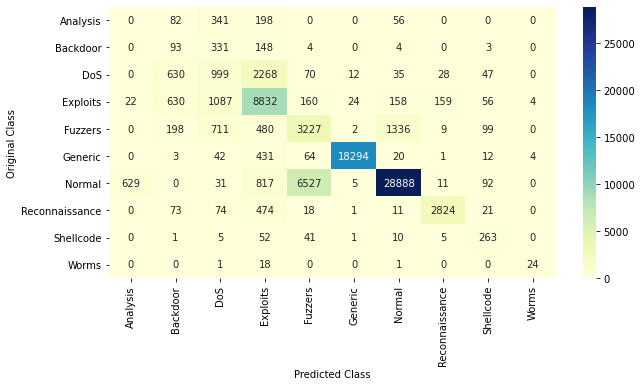

-------------------------------------------------- Precision matrix --------------------------------------------------


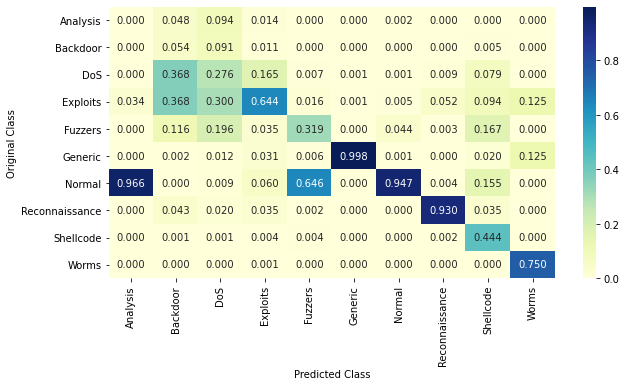

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


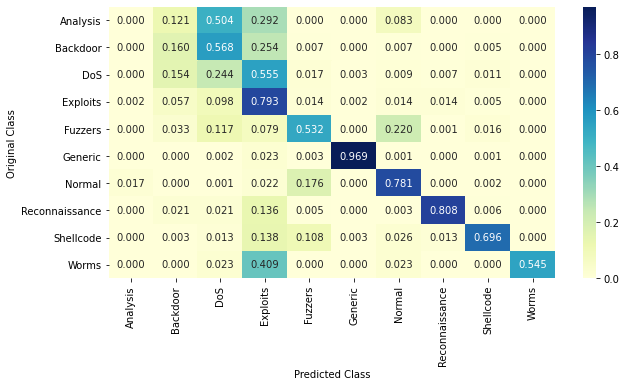

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [10]:
plot_confusion_matrix(y_test, sig_clf.predict(X_test_encoded))

### 2. Three Stage Classifier 

Classifies in the following 3 stages<br/>
1. Attack or Normal<br/>
2. Minority Class or Majority Class<br/>
3. Attack Category

In [12]:

class ThreeStageClassifier:
    
    def __init__(self):
        try:
            self.stage_1_model= pickle.load(open("stage_1_model.dat", "rb"))
        except:
            self.stage_1_model = None
            
        try:
            self.stage_2_model = pickle.load(open("stage_2_model.dat", "rb"))
        except:
            self.stage_2_model = None
            
        try:
            self.stage_3_model = pickle.load(open("stage_3_model.dat", "rb"))
        except:
            self.stage_3_model = None

        
    def fit(self, x_train, y_train, x_cv, y_cv):
        print('Training Stage 1...')
        
        # in first stage we train to classify whether attack or not
        y_train_stage_1 = [0 if y == 6 else 1 for y in y_train]
        y_cv_stage_1 = [0 if y == 6 else 1 for y in y_cv]
        
        if self.stage_1_model is None:
            self.stage_1_model = self.__train_xgb(x_train, y_train_stage_1, x_cv, y_cv_stage_1)
            pickle.dump(self.stage_1_model, open("stage_1_model.dat", "wb"))
        
        print('Training Stage 2...')
        # hstack to X
        x_train = np.hstack((x_train, np.array(y_train_stage_1).reshape(-1, 1)))
        x_cv = np.hstack((x_cv, np.array(y_cv_stage_1).reshape(-1, 1)))
        
        # in second stage, we train to classify majority or minority class
        minority_classes = [0, 1, 8, 9]
        y_train_stage_2 = [0 if y in minority_classes else 1 for y in y_train]
        y_cv_stage_2 = [0 if y in minority_classes else 1 for y in y_cv]
        
        if self.stage_2_model is None:
            self.stage_2_model = self.__train_xgb(x_train, y_train_stage_2, x_cv, y_cv_stage_2)
            pickle.dump(self.stage_2_model, open("stage_2_model.dat", "wb"))
        
        print('Training Stage 3...')
        # hstack to X
        x_train = np.hstack((x_train, np.array(y_train_stage_2).reshape(-1, 1)))
        x_cv = np.hstack((x_cv, np.array(y_cv_stage_2).reshape(-1, 1)))
        
        if self.stage_3_model is None:
            self.stage_3_model = self.__train_xgb(x_train, y_train, x_cv, y_cv)
            pickle.dump(self.stage_3_model, open("stage_3_model.dat", "wb"))
    
    def predict_proba(self, x):
        stage_1_pred = self.stage_1_model.predict_proba(x)
        stage_1_pred = np.array([np.argmax(x) for x in stage_1_pred]).reshape(-1, 1)
        x = np.hstack((x, stage_1_pred))
        
        stage_2_pred = self.stage_2_model.predict_proba(x)
        stage_2_pred = np.array([np.argmax(x) for x in stage_2_pred]).reshape(-1, 1)
        x = np.hstack((x, stage_2_pred))
        
        stage_3_pred = self.stage_3_model.predict_proba(x)
        return stage_3_pred
    
    def __get_acc(self, true_y, pred_y):
        return str(round(accuracy_score(true_y, pred_y) * 100, 2))
    
    def __train_xgb(self, x_train, y_train, x_cv, y_cv):
        alpha=[10, 50, 100, 500, 1000, 2000]
        cv_log_error_array=[]
        for i in alpha:
            x_cfl = XGBClassifier(n_estimators=i, nthread=3)
            x_cfl.fit(x_train, y_train)
            sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
            sig_clf.fit(x_train, y_train)
            predict_y = sig_clf.predict_proba(x_cv)
            cv_log_error_array.append(log_loss(y_cv, predict_y))
            
        best_alpha = np.argmin(cv_log_error_array)
        x_cfl = XGBClassifier(n_estimators=i, nthread=3)
        x_cfl.fit(x_train, y_train)
        sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
        sig_clf.fit(x_train, y_train)
        
        print("Training accuracy is " + self.__get_acc(y_train, [np.argmax(x) for x in sig_clf.predict_proba(x_train)]))
        print("Validation accuracy is " + self.__get_acc(y_cv, [np.argmax(x) for x in sig_clf.predict_proba(x_cv)]))
        return sig_clf

tsc = ThreeStageClassifier()
tsc.fit(X_train_encoded.todense(), y_train, X_cv_encoded.todense(), y_cv)

Training Stage 1...
Training accuracy is 97.15
Validation accuracy is 95.99
Training Stage 2...
Training accuracy is 98.25
Validation accuracy is 97.78
Training Stage 3...
Training accuracy is 90.65
Validation accuracy is 88.29


In [32]:
predict_y = tsc.predict_proba(X_train_encoded.todense())
print ("The train log loss is:", log_loss(y_train, predict_y))
predict_y = tsc.predict_proba(X_cv_encoded.todense())
print("The cross validation log loss is:", log_loss(y_cv, predict_y))
predict_y = tsc.predict_proba(X_test_encoded.todense())
print("The test log loss is:", log_loss(y_test, predict_y))

The train log loss is: 0.5622143640041848
The cross validation log loss is: 0.7228316193553956
The test log loss is: 1.521650609174352


In [39]:
print("Test accuracy score is " + str(accuracy_score(y_test, [np.argmax(x) for x in tsc.predict_proba(X_test_encoded.todense())])))

Test accuracy score is 0.7685832968954963


Number of misclassified points  23.141670310450372
-------------------------------------------------- Confusion matrix --------------------------------------------------


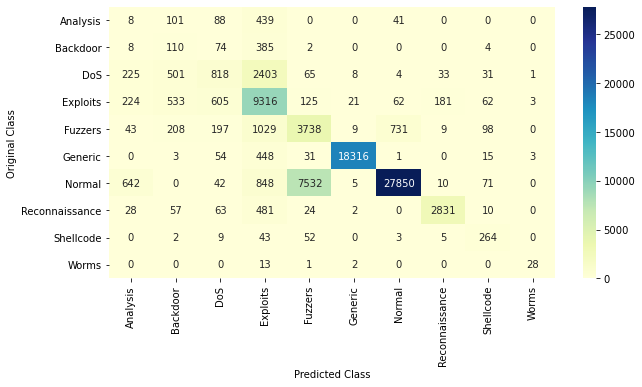

-------------------------------------------------- Precision matrix --------------------------------------------------


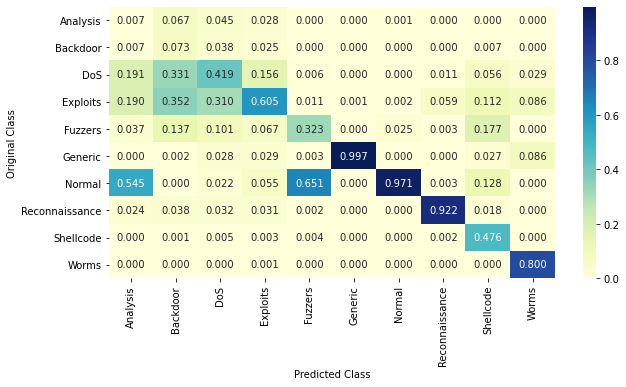

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


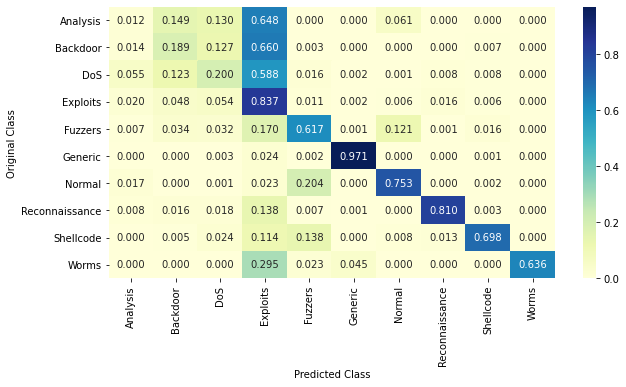

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [13]:
plot_confusion_matrix(y_test, tsc.predict_proba(X_test_encoded.todense()))

### 3. Three Stage Classifier with 2 classifiers ( minority / majority ) at stage 3

In [14]:
class ThreeStageClassifierV2:
    
    def __init__(self):
        try:
            self.stage_1_model= pickle.load(open("v2_stage_1_model.dat", "rb"))
        except:
            self.stage_1_model = None
            
        try:
            self.stage_2_model = pickle.load(open("v2_stage_2_model.dat", "rb"))
        except:
            self.stage_2_model = None
            
        try:
            self.stage_3_minority_model = pickle.load(open("v2_stage_3_minority_model.dat", "rb"))
        except:
            self.stage_3_minority_model = None
            
        try:
            self.stage_3_majority_model = pickle.load(open("v2_stage_3_majority_model.dat", "rb"))
        except:
            self.stage_3_majority_model = None
            
        self.minority_classes = [0, 1, 8, 9]
        self.majority_classes = [2, 3, 4, 5, 6, 7]
        
        self.minority_class_encoder = LabelEncoder().fit(self.minority_classes)
        self.majority_class_encoder = LabelEncoder().fit(self.majority_classes)

        
    def fit(self, x_train, y_train, x_cv, y_cv):
        print('Training Stage 1...')
        
        # in first stage we train to classify whether attack or not
        y_train_stage_1 = [0 if y == 6 else 1 for y in y_train]
        y_cv_stage_1 = [0 if y == 6 else 1 for y in y_cv]
        
        if self.stage_1_model is None:
            self.stage_1_model = self.__train_xgb(x_train, y_train_stage_1, x_cv, y_cv_stage_1)
            pickle.dump(self.stage_1_model, open("v2_stage_1_model.dat", "wb"))
        
        print('Training Stage 2...')
        # hstack to X
        x_train = np.hstack((x_train, np.array(y_train_stage_1).reshape(-1, 1)))
        x_cv = np.hstack((x_cv, np.array(y_cv_stage_1).reshape(-1, 1)))
        
        # in second stage, we train to classify majority or minority class      
        y_train_stage_2 = np.array([0 if y in self.minority_classes else 1 for y in y_train])
        y_cv_stage_2 = np.array([0 if y in self.minority_classes else 1 for y in y_cv])
        
        if self.stage_2_model is None:
            self.stage_2_model = self.__train_xgb(x_train, y_train_stage_2, x_cv, y_cv_stage_2)
            pickle.dump(self.stage_2_model, open("v2_stage_2_model.dat", "wb"))
        
        print('Training Stage 3 for minority classes...')
        minority_train_mask = [y_train_stage_2 == 0]
        x_train_minority = x_train[tuple(minority_train_mask)]
        y_train_minority = self.minority_class_encoder.transform(y_train[tuple(minority_train_mask)])
        
        minority_cv_mask = [y_cv_stage_2 == 0]
        x_cv_minority = x_cv[tuple(minority_cv_mask)]
        y_cv_minority = self.minority_class_encoder.transform(y_cv[tuple(minority_cv_mask)])
        
        if self.stage_3_minority_model is None:
            self.stage_3_minority_model = self.__train_xgb(x_train_minority, y_train_minority, x_cv_minority, y_cv_minority)
            pickle.dump(self.stage_3_minority_model, open("v2_stage_3_minority_model.dat", "wb"))
            
            
        print('Training Stage 3 for majority classes...')
        majority_train_mask = [y_train_stage_2 == 1]
        x_train_majority = x_train[tuple(majority_train_mask)]
        y_train_majority = self.majority_class_encoder.transform(y_train[tuple(majority_train_mask)])
        
        majority_cv_mask = [y_cv_stage_2 == 1]
        x_cv_majority = x_cv[tuple(majority_cv_mask)]
        y_cv_majority = self.majority_class_encoder.transform(y_cv[tuple(majority_cv_mask)])
        
        if self.stage_3_majority_model is None:
            self.stage_3_majority_model = self.__train_xgb(x_train_majority, y_train_majority, x_cv_majority, y_cv_majority)
            pickle.dump(self.stage_3_majority_model, open("v2_stage_3_majority_model.dat", "wb"))
    
    def predict_proba(self, x):
        stage_1_pred = self.stage_1_model.predict_proba(x)
        stage_1_pred = np.array([np.argmax(x) for x in stage_1_pred]).reshape(-1, 1)
        x = np.hstack((x, stage_1_pred))
        
        stage_2_pred = self.stage_2_model.predict_proba(x)
        stage_2_pred = np.array([np.argmax(x) for x in stage_2_pred])
        
        minority_mask = [stage_2_pred == 0]
        majority_mask = [stage_2_pred == 1]
        
        x_minority = x[tuple(minority_mask)]
        x_majority = x[tuple(majority_mask)]
        
        stage_3_minority_pred = self.stage_3_minority_model.predict_proba(x_minority)
        stage_3_minority_pred = np.array([np.argmax(x) for x in stage_3_minority_pred])
        stage_3_minority_pred = self.minority_class_encoder.inverse_transform(stage_3_minority_pred)
        
        stage_3_majority_pred = self.stage_3_majority_model.predict_proba(x_majority)
        stage_3_majority_pred = np.array([np.argmax(x) for x in stage_3_majority_pred])
        stage_3_majority_pred = self.majority_class_encoder.inverse_transform(stage_3_majority_pred)
        
        pred = []
        pred_index = -1
        
        minority_index = -1
        majority_index = -1
        
        for row in x:
            pred_index = pred_index + 1
            
            if minority_mask[0][pred_index]:
                minority_index = minority_index + 1
                pred.append(stage_3_minority_pred[minority_index])
            elif majority_mask[0][pred_index]:
                majority_index = majority_index + 1
                pred.append(stage_3_majority_pred[majority_index])
            else:
                raise Exception("Error: no prediction found")
        
        return np.array(pred).reshape(-1, 1)
    
    def __get_acc(self, true_y, pred_y):
        return str(round(accuracy_score(true_y, pred_y) * 100, 2))
    
    def __train_xgb(self, x_train, y_train, x_cv, y_cv):
        alpha=[10, 50, 100, 500, 1000, 2000]
        cv_log_error_array=[]
        for i in alpha:
            x_cfl = XGBClassifier(n_estimators=i, nthread=3)
            x_cfl.fit(x_train, y_train)
            sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
            sig_clf.fit(x_train, y_train)
            predict_y = sig_clf.predict_proba(x_cv)
            cv_log_error_array.append(log_loss(y_cv, predict_y))
            
        best_alpha = np.argmin(cv_log_error_array)
        x_cfl = XGBClassifier(n_estimators=i, nthread=3)
        x_cfl.fit(x_train, y_train)
        sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
        sig_clf.fit(x_train, y_train)
        
        print("Training accuracy is " + self.__get_acc(y_train, [np.argmax(x) for x in sig_clf.predict_proba(x_train)]))
        print("Validation accuracy is " + self.__get_acc(y_cv, [np.argmax(x) for x in sig_clf.predict_proba(x_cv)]))
        return sig_clf

In [15]:
tscv2 = ThreeStageClassifierV2()
tscv2.fit(X_train_encoded.todense(), y_train, X_cv_encoded.todense(), y_cv)

Training Stage 1...
Training accuracy is 97.15
Validation accuracy is 95.99
Training Stage 2...
Training accuracy is 98.25
Validation accuracy is 97.78
Training Stage 3 for minority classes...
Training accuracy is 78.53
Validation accuracy is 62.9
Training Stage 3 for majority classes...
Training accuracy is 91.05
Validation accuracy is 89.0


Finding logloss is difficult to find since the final stage classifiers do not provide probability scores for the other classes<br>
i.e The majority class classifier does not provide probability scores for minority classes and vice verse

In [41]:
print("Test accuracy score is " + str(accuracy_score(y_test, tscv2.predict_proba(X_test_encoded.todense()))))

Test accuracy score is 0.7682189185249964


Number of misclassified points  23.178108147500364
-------------------------------------------------- Confusion matrix --------------------------------------------------


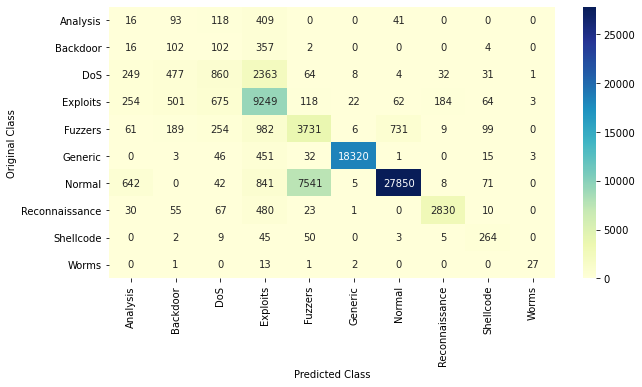

-------------------------------------------------- Precision matrix --------------------------------------------------


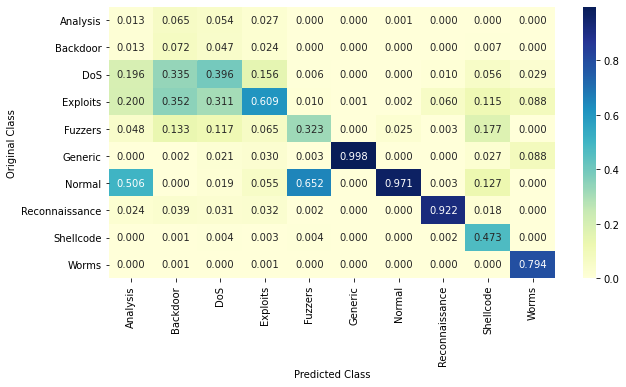

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


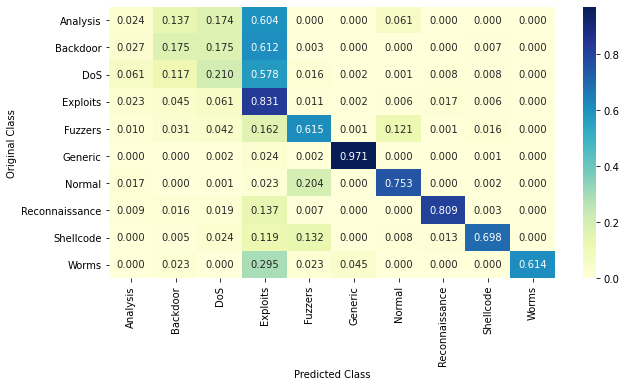

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [16]:
plot_confusion_matrix(y_test, tscv2.predict_proba(X_test_encoded.todense()))

In [2]:
summary_table = PrettyTable()
summary_table.field_names = ['Sr. No.', 'Classifier', 'Log Loss', 'Overall Accuracy', 'Misclassification']
summary_table.add_row([str(1), 
                           "Standard XGB", 
                           "0.6294", 
                           "77.05 %", 
                           "22.94 %"])
summary_table.add_row([str(2), 
                           "3 Stage XGB Classifier", 
                           "1.5216", 
                           "76.85 %", 
                           "23.14 %"])

summary_table.add_row([str(3), 
                           "3 Stage XGB Classifier with 2 final stage classifiers", 
                           "NA", 
                           "76.82 %", 
                           "23.17 %"])

print(summary_table)

+---------+-------------------------------------------------------+----------+------------------+-------------------+
| Sr. No. |                       Classifier                      | Log Loss | Overall Accuracy | Misclassification |
+---------+-------------------------------------------------------+----------+------------------+-------------------+
|    1    |                      Standard XGB                     |  0.6294  |     77.05 %      |      22.94 %      |
|    2    |                 3 Stage XGB Classifier                |  1.5216  |     76.85 %      |      23.14 %      |
|    3    | 3 Stage XGB Classifier with 2 final stage classifiers |    NA    |     76.82 %      |      23.17 %      |
+---------+-------------------------------------------------------+----------+------------------+-------------------+
